# Pokémon Generations Analysis

[Pokémon](https://en.wikipedia.org/wiki/Pok%C3%A9mon) is a multimedia japanese franchise firtly developed as a video game for the original game boy in 1996. The following report uses data made availiable by [Keith Galli](https://github.com/KeithGalli) that contains information about all the pokémons from the 6 first generations. This report aims to answer the following questions:

* What is the most common and rare type of pokémon?
* What is the strongest and weakest pokémon?
* What is the strongest and weakest pokémon generation?
* Can pokémons be grouped according to their characteristics?



## Setting up the data

We start our analysis by loading and getting some general information about the data.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("https://raw.githubusercontent.com/KeithGalli/pandas/master/pokemon_data.csv")

df.describe(include='all')

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,800.000000,800,800,414,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800
unique,NaN,800,18,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,Staryu,Water,Flying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,1,112,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735
mean,362.813750,NaN,NaN,NaN,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,NaN
std,208.343798,NaN,NaN,NaN,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,NaN
min,1.000000,NaN,NaN,NaN,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,NaN
25%,184.750000,NaN,NaN,NaN,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,NaN
50%,364.500000,NaN,NaN,NaN,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,NaN
75%,539.250000,NaN,NaN,NaN,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,NaN


We have 12 columns with auto descriptive names and 800 rows. The **Name**, **Type 1** and **Type 2** columns contain text values. The **Legendary** column contains boolean values. The rest of the columns are numerical. Let us check the first rows of the dataframe.

In [2]:
df.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


The **#** columns represents the pokedex number of the pokémon. We have some *Mega* pokémons, which are just a stronger version of specific pokémons. We will be removing them from the data.

In [3]:
df = df[~df['Name'].str.contains("Mega")].reset_index(drop=True)
df.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
4,5,Charmeleon,Fire,NaN,58,64,58,80,65,80,1,False


Now that we removed the *Mega* pokémon from the data, let us see how many pokémons we have got left and save the tidy data in a csv file.

In [4]:
print("Number of pokémons:", df['Name'].nunique())
df.to_csv("pokemon.csv")

Number of pokémons: 751


## Pokémon Types

Each pokémon has mandatorily one and a maximum of two types. Let us see how many different types we have accross all generations.

In [5]:
ntypes = pd.concat([df['Type 1'], df['Type 2']]).nunique()
print("Number of distinct pokémon types:", ntypes)
types = pd.concat([df['Type 1'], df['Type 2']]).unique()
print("Pokémon types:",types)

Number of distinct pokémon types: 18
Pokémon types: ['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying' nan]


We have 18 different types of pokémons. The *nan* value appears because not all pokémons have two types. Let us see the proportion of pokémons with two types.

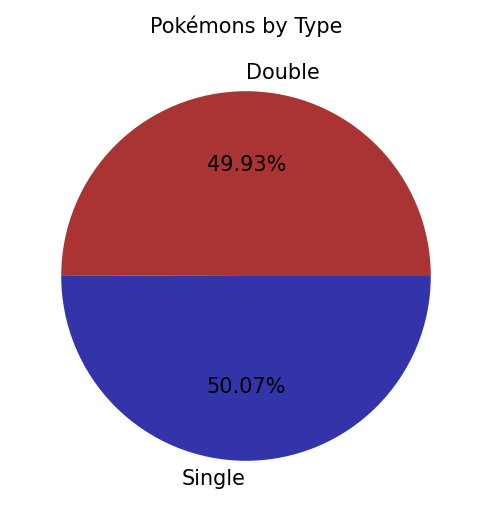

In [23]:
df['ntype'] = np.where(df['Type 2'].isna(), 'Single', 'Double')
df_by_ntype = df.groupby('ntype')['Name'].count()

fig, ax = plt.subplots(figsize=(4,4), dpi=150)
ax.pie(df_by_ntype, labels=df_by_ntype.index, autopct="%.2f%%", colors=['#AA3333', '#3333AA'])
ax.set_title("Pokémons by Type", fontdict={'fontsize':10})
plt.show()

The amount of single and double type pokémon is very balanced. Let us see if this behavior is homogeneous for all generations

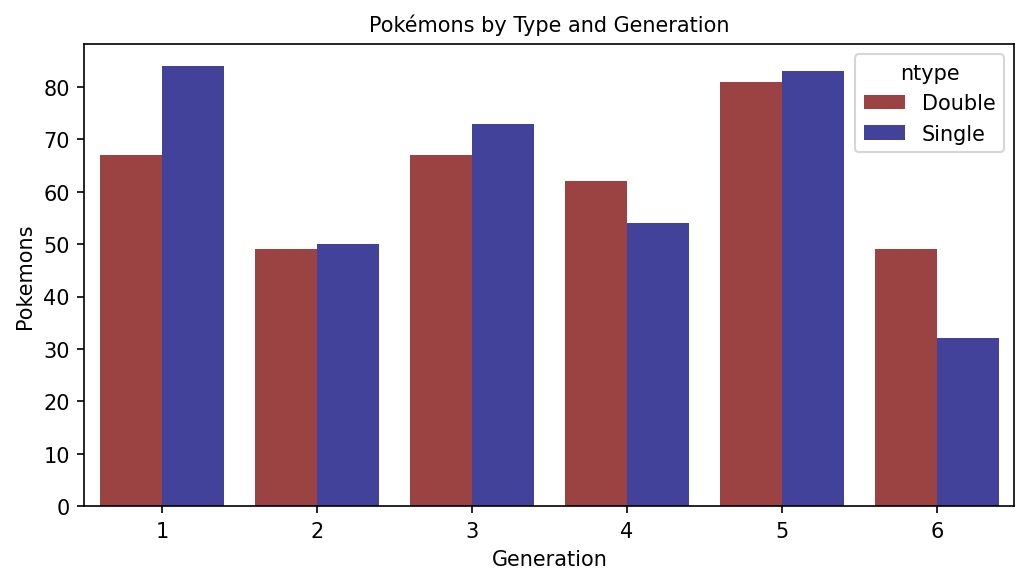

In [37]:
df_by_generation_ntype = df.groupby(['Generation', 'ntype']).agg(Pokemons=('Name', pd.Series.count)).reset_index()
fig, ax = plt.subplots(figsize=(8,4), dpi=150)
ntype_palette = {'Single':'#3333AA', 'Double':'#AA3333'}
sns.barplot(x='Generation', y='Pokemons', hue='ntype', data=df_by_generation_ntype, palette=ntype_palette, ax=ax)
ax.set_title("Pokémons by Type and Generation", fontdict={'fontsize':10})
plt.show()

The amount of single and double type pokémons is pretty much balanced across all generations, with the first and sixth having the largest differences. The amount of double type pokémon is larger only in the fourth and sixth generations. Let us see how many pokémons we have for each type.

In [41]:
df_pokemon_by_type1 = df.groupby(['Type 1']).agg(Pokemons=('Name', pd.Series.nunique)).reset_index()
df_pokemon_by_type2 = df.groupby(['Type 2']).agg(Pokemons=('Name', pd.Series.nunique)).reset_index()
df_pokemon_by_type = df_pokemon_by_type1.merge(df_pokemon_by_type2, how='outer', left_on='Type 1', right_on='Type 2',
                                               suffixes=('_1', '_2'))
df_pokemon_by_type['Pokemons'] = df_pokemon_by_type['Pokemons_1']+df_pokemon_by_type['Pokemons_2']
df_pokemon_by_type = df_pokemon_by_type[['Type 1', 'Pokemons']].rename(columns={'Type 1':'Type'})\
                                                               .sort_values(['Pokemons'], ascending=False)\
                                                               .reset_index(drop=True)
df_pokemon_by_type

,Type,Pokemons
0,Water,121
1,Normal,98
2,Flying,95
3,Grass,91
4,Psychic,80
5,Bug,68
6,Ground,63
7,Fire,59
8,Poison,59
9,Rock,55


Water type pokémons are the most common ones and the fairy type ones are the rarest. This can maybe explained by the fact that fairy pokémons were introduced in the latter generations.

## Pokémon Strength Comparison

